In [2]:
import os

HOME = os.getcwd()
print(HOME)

/Users/devasenan/Documents/projects/mfs/final_version


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance as dist

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [82]:
from key_point_extractor_utils import get_rectangles

class MaskBlender:
    def __init__(self, layout_path, mat_path, src_path):
        self.layout_path = layout_path
        self.layout_img = cv2.imread(layout_path)
        self.mat_path = mat_path
        
        self.src_img = cv2.imread(src_path)
        
        self.rectangles = get_rectangles(self.layout_path, self.mat_path)
        self.all_rectangles = self.rectangles[0].copy()
        self.all_rectangles.extend(self.rectangles[1])    
        
        # processed_img_variables
        self.rescaled_subject = None

        self.selected_rect = None
        self.selected_warp = None
        self.selected_gray_mask = None
        
        
    def __isIn(self, point, rectangle):
        x, y = point
        vertices = np.append(rectangle, [rectangle[0]], axis=0)
    
        crossing_number = 0
        for i in range(len(vertices) - 1):
            x1, y1 = vertices[i]
            x2, y2 = vertices[i + 1]
            if ((y1 <= y < y2) or (y2 <= y < y1)) and (x < (x1 - x2) * (y - y2) / (y1 - y2) + x2):
                crossing_number += 1
        return crossing_number % 2 == 1

    def selectRectangle(self, rectangles, cursorPosition):
        for rect in rectangles:
            if self.__isIn(cursorPosition, rect):
                return rect
        return -1
        
    def __read_mask(self, mask_path):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        return bw_img

    def __rescale_subject_img(self, subject_path, scale_percent):
        temp = cv2.imread(subject_path)
        subject_img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        
        w_rescale, h_rescale = (subject_img.shape[1]*scale_percent)//100, (subject_img.shape[0]*scale_percent)//100
        h, w = subject_img.shape[:-1]
        self.rescaled_subject = cv2.resize(subject_img, [w_rescale, h_rescale], interpolation=cv2.INTER_AREA)
        
    def __calculate_w_h(self, polygon):
        n_pts = len(polygon)
        edge_2 = polygon[1:-1]
        edge_3 = polygon[2:]
        all_distances = {}
        
        for edge in [edge_2, edge_3]:
            p1 = edge[0]
            p2 = edge[1]
            # print(p1, p2)
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            all_distances[dist] = [p1, p2]
            # print(all_distances)
        return [*all_distances.keys()]
    
    def __replicate_subject(self, polygon):
        h_subject, w_subject = self.rescaled_subject.shape[:2]

        h_base, _ = self.layout_img.shape[:2]
        _, w_base = self.__calculate_w_h(polygon)
        
        num_of_tiles_per_row = round(h_base / h_subject)-1
        num_of_tiles_per_col = round(w_base / w_subject)
        # print(num_of_tiles_per_row, num_of_tiles_per_col)

        dup_cols = self.rescaled_subject.copy()
        ## duplicate the subject image
        for i in range(num_of_tiles_per_col):
            dup_cols = np.concatenate([dup_cols, self.rescaled_subject], axis = 1)
        dup_rows = dup_cols.copy()
        for i in range(num_of_tiles_per_row):
            dup_rows = np.concatenate([dup_rows, dup_cols], axis=0)
        
        duplicated_tiles = dup_rows.copy()
        # plt.imshow(duplicated_tiles)
        return duplicated_tiles
    
    def __perspective_warp(self, polygon):
        if len(polygon) > 4:
            sorted_pts = self.__reduce_points(polygon)
        else:
            sorted_pts = polygon

        duplicated_sub = self.__replicate_subject(sorted_pts)
        # plt.imshow(duplicated_sub)
        h_base, w_base, c_base = self.layout_img.shape
        h_subject, w_subject = duplicated_sub.shape[:2]
        pts1 = np.float32([[0, 0], [w_subject, 0], [w_subject, h_subject], [0, h_subject]])
        pts2 = np.float32(sorted_pts)
        # print(pts1, pts2)

        transformation_matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # print(transformation_matrix)
        warped_img = cv2.warpPerspective(duplicated_sub, transformation_matrix, (w_base, h_base))
        # plt.imshow(warped_img)
        return warped_img
    
    def __combine_warps(self):        
        combined_warp = np.zeros(self.layout_img.shape, dtype=np.uint8)
        for polygon in self.all_rectangles:
            warp = self.__perspective_warp(polygon)
            combined_warp = cv2.bitwise_or(combined_warp, warp)
        return combined_warp
    
    def implant_overlay(self, subject_path, mask_path, rescale_percent):
        self.__rescale_subject_img(subject_path, rescale_percent)
        
        selected_mask = self.__read_mask(mask_path)
        self.selected_gray_mask = cv2.cvtColor(selected_mask, cv2.COLOR_RGB2GRAY)
        overlay_coordinates = np.where(self.selected_gray_mask > 0)

        self.selected_warp = self.__combine_warps()
        
        transformed_warp = cv2.bitwise_and(self.selected_warp, selected_mask)
    
        return transformed_warp

In [83]:
layout_path = "layout_img/img3.jpeg"
layout_mat_path = "layout_img/img3.txt"
src_img_path = 'src_img/img3.jpeg'

st = time.time()
blender = MaskBlender(
        layout_path,
        layout_mat_path,
        src_img_path,
        )
et = time.time()
"{:.3f}s".format(et-st)

'0.641s'

In [93]:
subject_rescale_percent = 70
mask_path = 'mask_img/wall01.png'
# product_path = 'product_img/NeroSensation.jpg'
product_path = 'product_img/95_floral wallpaper texture-seamless.jpg'

transformed_img = blender.implant_overlay(product_path, 
                                    mask_path,
                                    subject_rescale_percent,
                                    )

cv2.imwrite("outs/out.jpg", 
            cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))

True

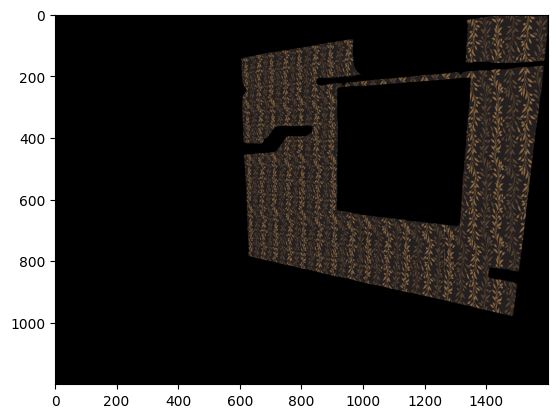

In [92]:
plt.imshow(transformed_img)